In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
confThreshold = 0.5
nmsThreshold = 0.6

with open('benchmark/data/coco.names', 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')


In [3]:
# Load a network
net = cv.dnn.readNet('benchmark/cfg/yolov4.cfg', 'benchmark/weights/yolov4.weights', 'darknet')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
outNames = net.getUnconnectedOutLayersNames()




In [4]:
layerNames = net.getLayerNames()
lastLayerId = net.getLayerId(layerNames[-1])
lastLayer = net.getLayer(lastLayerId)
print(lastLayer.type)

Region


In [5]:
def postprocess_1(outs, sample_cnt):

    out_bboxes = outs[:, :, 0:4]
    out_bbox_confs = outs[:, :, 4]
    out_class_confs = outs[:, :, 5:]

    out_class_confs_max_ind = np.argmax(out_class_confs, axis=2)

    # get conf max values
    # taken from https://stackoverflow.com/questions/42519475/python-numpy-argmax-to-max-in-multidimensional-array
    n, h = out_class_confs.shape[:2]
    N, H = np.ogrid[:n,:h]
    out_class_confs_max = out_class_confs[N, H, out_class_confs_max_ind]


    # Get conf_max mask
    out_class_confs_max_mask = out_class_confs_max[:] >= confThreshold

    out_bboxes_cut = []
    out_class_confs_max_cut = []
    out_class_confs_max_ind_cut = []
    
    for i in range(sample_cnt):
        # Remove un-masking bboxes, conf_max (class score), classIds
        bboxes_cut = out_bboxes[i, :, :][out_class_confs_max_mask[i, :]]
        class_confs_max_cut = out_class_confs_max[i, : ][out_class_confs_max_mask[i, :]]
        class_confs_max_ind_cut = out_class_confs_max_ind[i, :][out_class_confs_max_mask[i, :]]

        out_bboxes_cut.append(bboxes_cut)
        out_class_confs_max_cut.append(class_confs_max_cut)
        out_class_confs_max_ind_cut.append(class_confs_max_ind_cut)

    return out_bboxes_cut, out_class_confs_max_cut, out_class_confs_max_ind_cut
    
def postprocess_2(frame, boxes_, confidences, classIds):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    def drawPred(classId, conf, left, top, right, bottom):
        # Draw a bounding box.
        cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0))

        label = '%.2f' % conf

        # Print a label of class.
        if classes:
            assert(classId < len(classes))
            label = '%s: %s' % (classes[classId], label)

        labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        top = max(top, labelSize[1])
        cv.rectangle(frame, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), (255, 255, 255), cv.FILLED)
        cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # convert box into integer
    boxes = []
    for idx in range(boxes_.shape[0]):
        center_x = int(boxes_[idx, 0] * frameWidth)
        center_y = int(boxes_[idx, 1] * frameHeight)
        width = int(boxes_[idx, 2] * frameWidth)
        height = int(boxes_[idx, 3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        boxes.append([left, top, width, height])

    
    t0 = time.time()
    indices = []
    classIds = np.array(classIds)
    boxes = np.array(boxes)
    confidences = np.array(confidences)
    unique_classes = set(classIds)
    for cl in unique_classes:
        class_indices = np.where(classIds == cl)[0]
        conf = confidences[class_indices]
        box  = boxes[class_indices].tolist()
        nms_indices = cv.dnn.NMSBoxes(box, conf, confThreshold, nmsThreshold)
        nms_indices = nms_indices[:, 0] if len(nms_indices) else []
        indices.extend(class_indices[nms_indices])
    t1 = time.time()
#     print("NMS: {}".format(t1 - t0))
    
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [6]:
frame1 = cv.imread('benchmark/data/dog.jpg')
frame2 = cv.imread('benchmark/data/eagle.jpg')
frame3 = cv.imread('benchmark/data/person.jpg')

# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImages([frame1, frame2, frame3], size=(608, 608), swapRB=True, crop=False, ddepth=cv.CV_8U)

# Run a model
net.setInput(blob, scalefactor=1/255.0)
outs_ = net.forward(outNames)
outs = np.concatenate(outs_, axis=1)



In [9]:
%%timeit

for i in range(100):
    
    boxes_list, confidences_list, classIds_list = postprocess_1(outs, 3)
    
    postprocess_2(frame1, boxes_list[0], confidences_list[0], classIds_list[0])
    postprocess_2(frame2, boxes_list[1], confidences_list[1], classIds_list[1])
    postprocess_2(frame3, boxes_list[2], confidences_list[2], classIds_list[2])


# print(boxes_list)
# print(confidences_list)
# print(classIds_list)

1 loop, best of 3: 1.45 s per loop


In [8]:
boxes_list

NameError: name 'boxes_list' is not defined

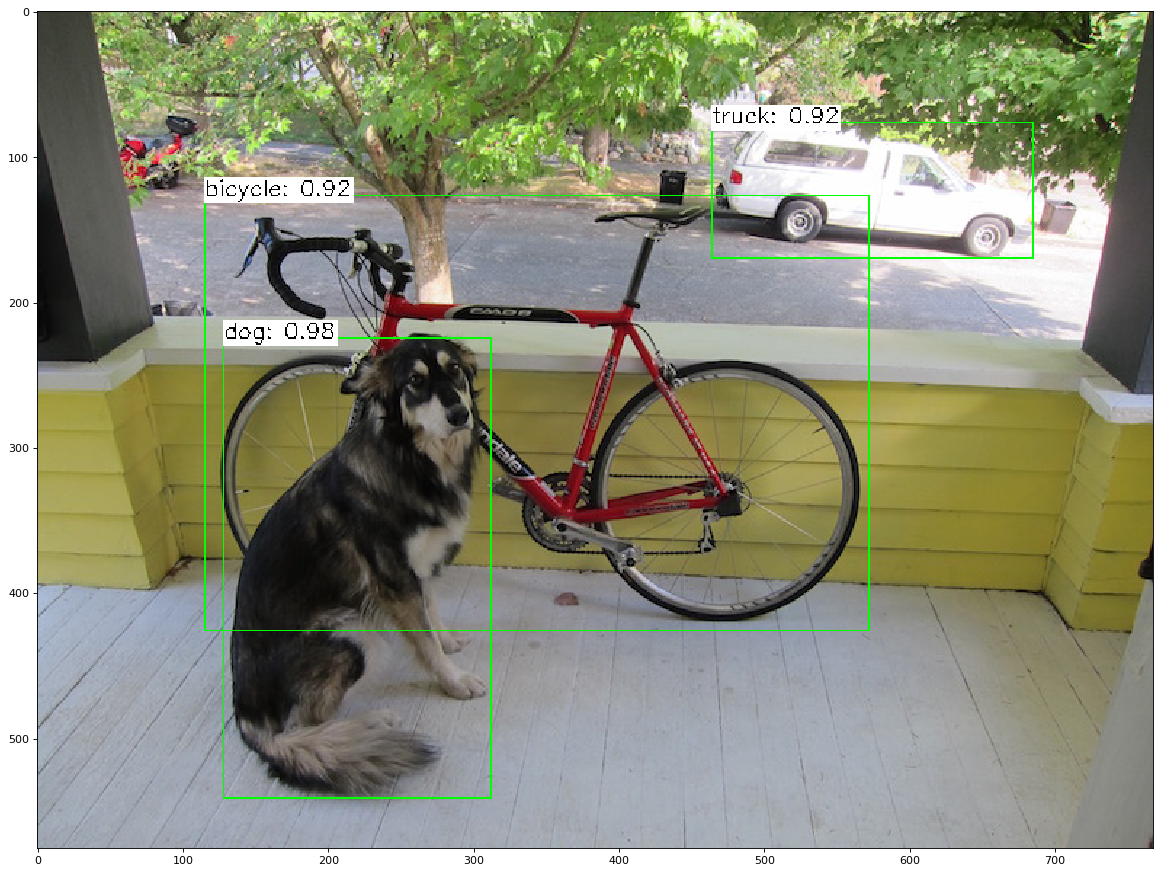

In [10]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv.cvtColor(frame1, cv.COLOR_BGR2RGB))

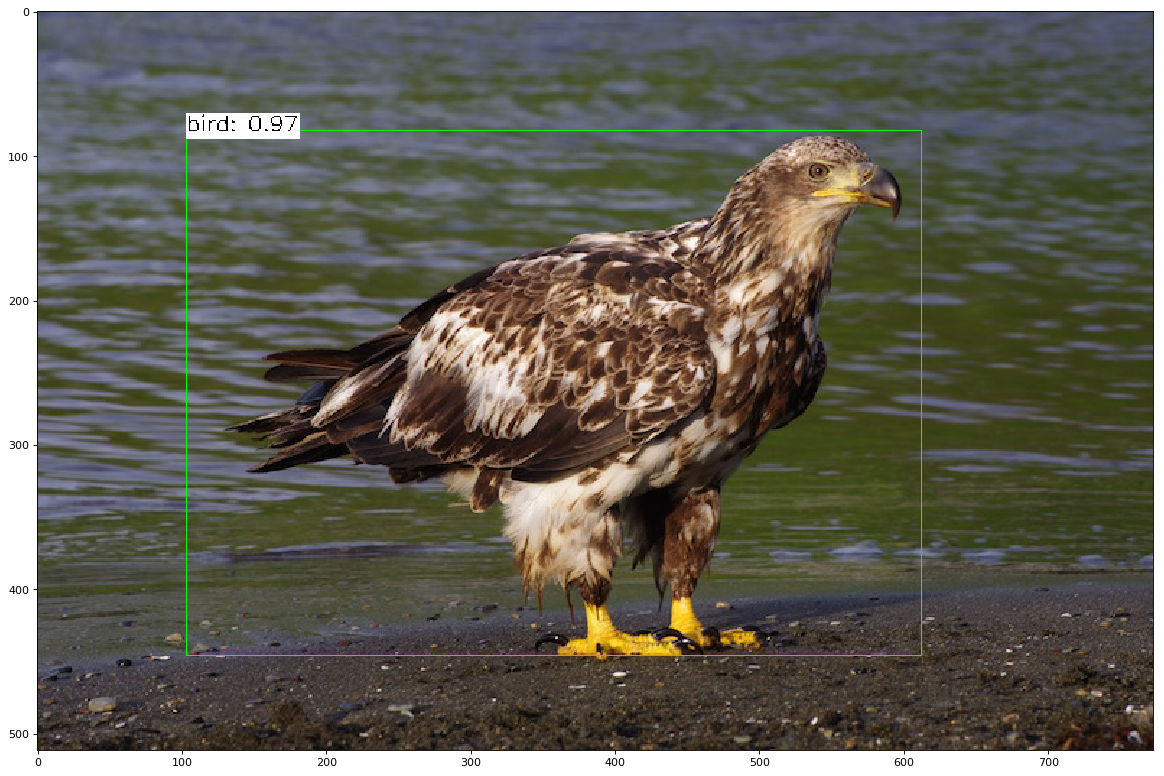

In [11]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv.cvtColor(frame2, cv.COLOR_BGR2RGB))

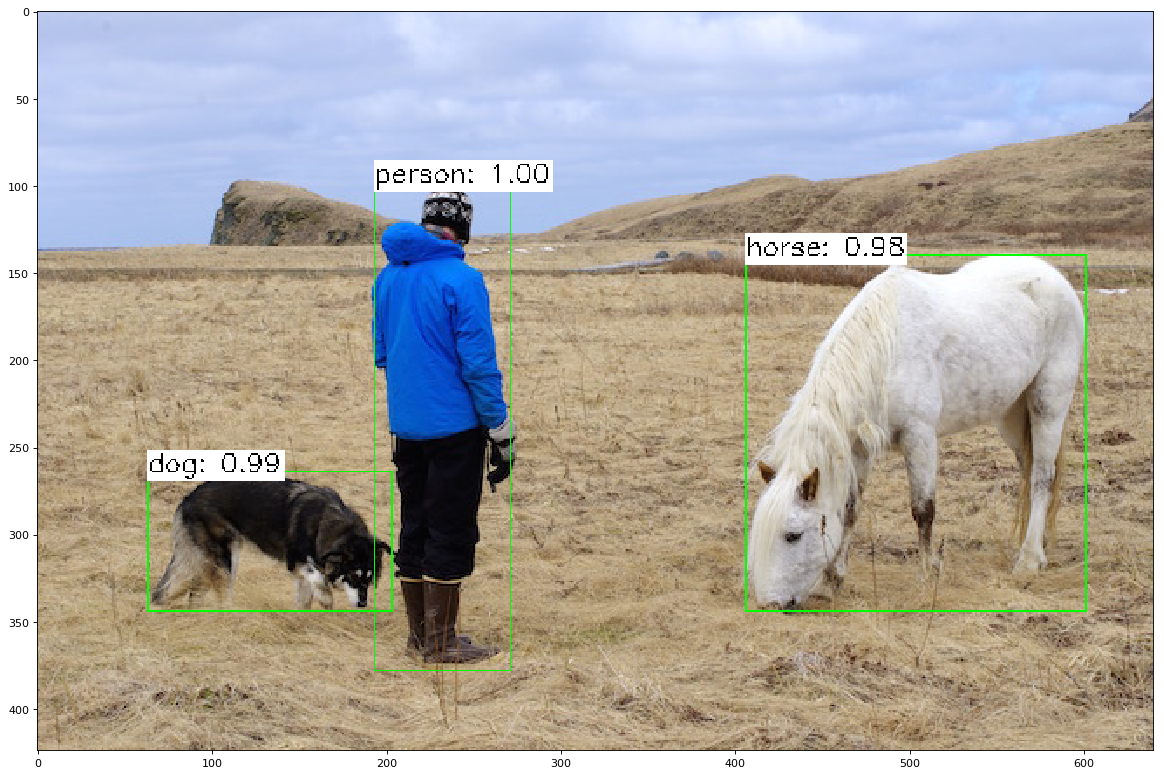

In [12]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(cv.cvtColor(frame3, cv.COLOR_BGR2RGB))